### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSSSBSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)
df.groupby('station').count().show()

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12249
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     14.9| 30.4132| -86.6635|       PRCP|US1FLOK0014|    38|[00 00 00 00 B0 5...|2009.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     5|[40 5A F0 5A 80 5...|1999.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     3|[20 5B 78 5B 48 5...|2000.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    40|[90 55 E0 54 A0 5...|2001.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    12|[E0 54 30 54 30 5...|2002.0|BSSSBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows

+-----------+

### Select data for a particular station and measurement type

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and year>=1980 and year<1990 "%('TMAX')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(200)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and year>=1980 and year<1990 
214 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    102.7| 31.2975| -85.8997|       TMAX|USC00012675|    10|[30 55 E0 54 08 5...|1980.0|BSSSBSBS|
|    102.7| 31.2975| -85.8997|       TMAX|USC00012675|    19|[00 7E 00 7E 00 7...|1981.0|BSSSBSBS|
|    102.7| 31.2975| -85.8997|       TMAX|USC00012675|    14|[50 57 A0 57 58 5...|1982.0|BSSSBSBS|
|    102.7| 31.2975| -85.8997|       TMAX|USC00012675|    17|[00 7E 00 7E 80 5...|1983.0|BSSSBSBS|
|    102.7| 31.2975| -85.8997|       TMAX|USC00012675|    26|[30 54 00 58 80 5...|1984.0|BSSSBSBS|
|    102.7| 31.2975| -85.8997|       TMAX|USC00012675|    29|[00 5C C8 5A F0 5...|1985.0|BSSSBSBS|
|    102.7| 31.2975| -

(214, 365)

### Script for plotting yearly plots

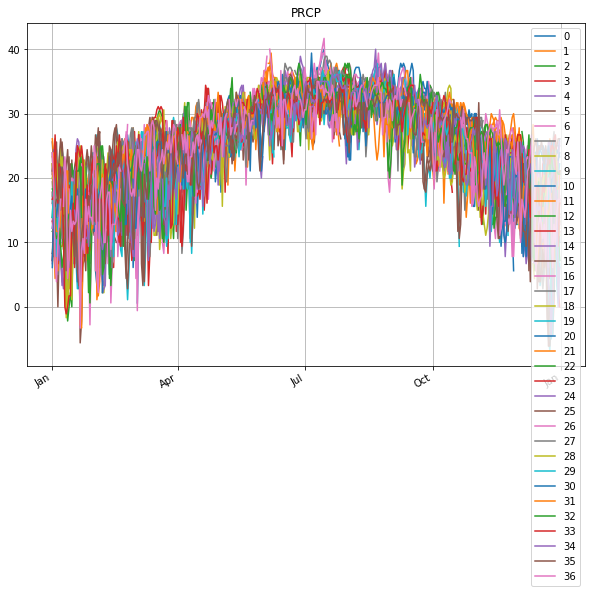

In [4]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:37,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [9]:
def plot_pair(pair,s,func):
    j=0
    fig,X=subplots(1,len(pair),figsize=(16,6))
    axes=X.reshape(len(pair))
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,s,fig,axis)
        
def plot_valid(m,s,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)

def plot_stat(m,s,fig,axis):
    valid_m=STAT[m][s]
    YP.plot(valid_m,fig,axis,title=m+' Observations by Calendar Day')

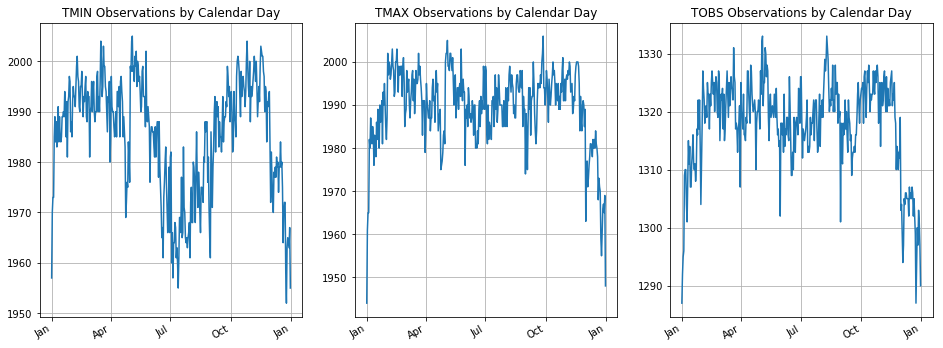

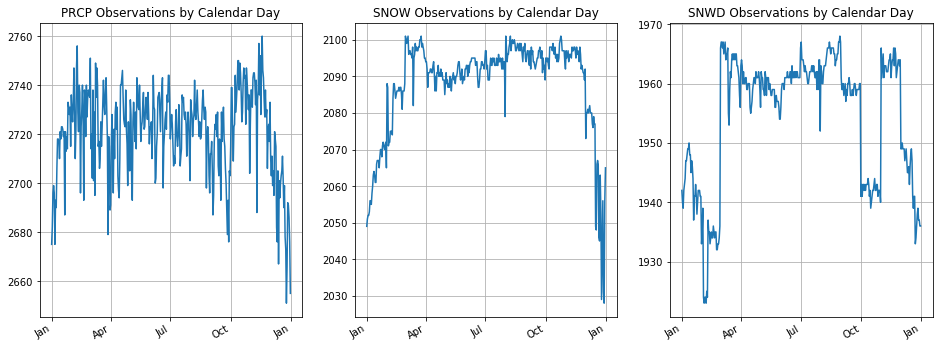

In [10]:
plot_pair(['TMIN','TMAX','TOBS'],'NE',plot_stat)
plot_pair(['PRCP','SNOW','SNWD'],'NE',plot_stat)


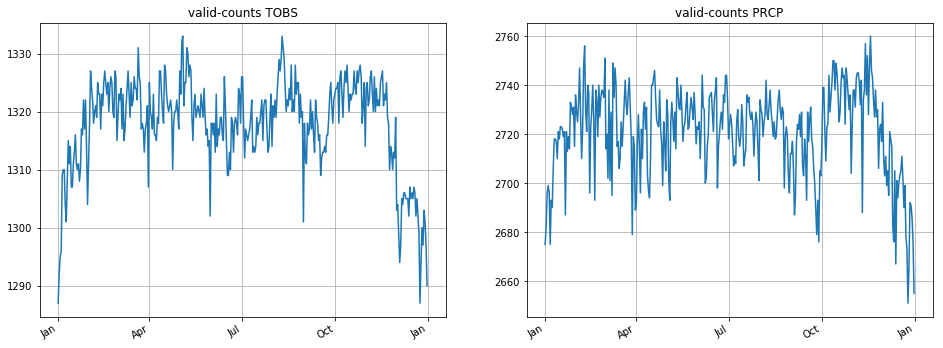

In [11]:
plot_pair(['TOBS','PRCP'],'',plot_valid)

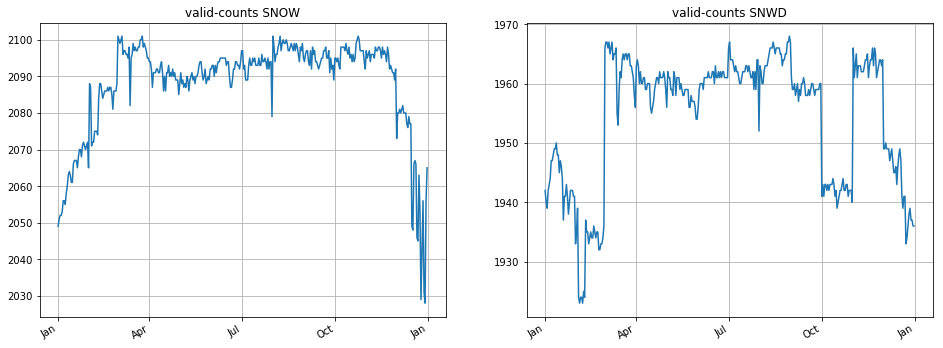

In [12]:
plot_pair(['SNOW', 'SNWD'],'',plot_valid)

### Plots of mean and std of observations

In [24]:
def plot_pair(pair,s,func):
    j=0
    fig,X=subplots(1,len(pair),figsize=(16,6),sharey=True)
    if len(pair) > 1:
        axes=X.reshape(len(pair))
        sharedx = axes[0]
    else:
        axes = [X]
    
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,s,fig,axis)
        
def plot_mean_std(m,s,fig,axis):
    mean=STAT[m]['Mean'] / 10
    std=np.sqrt(STAT[m]['Var']) / 10
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    axis.set_ylabel('mm')
    YP.plot(graphs,fig,axis,title=m+' Mean+-std',labels=['+std',m,'-std'])

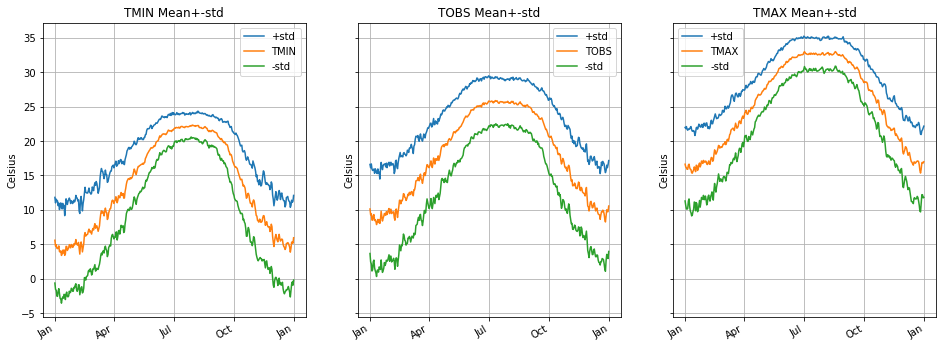

In [14]:
plot_pair(['TMIN','TOBS','TMAX'],'',plot_mean_std)

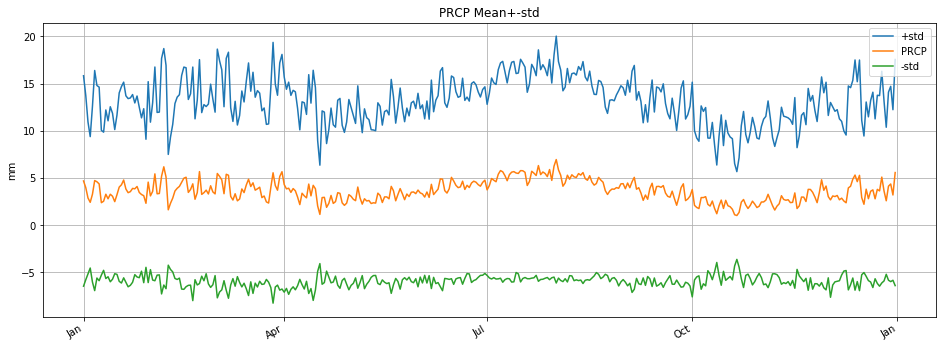

In [25]:
plot_pair(['PRCP'],'',plot_mean_std)

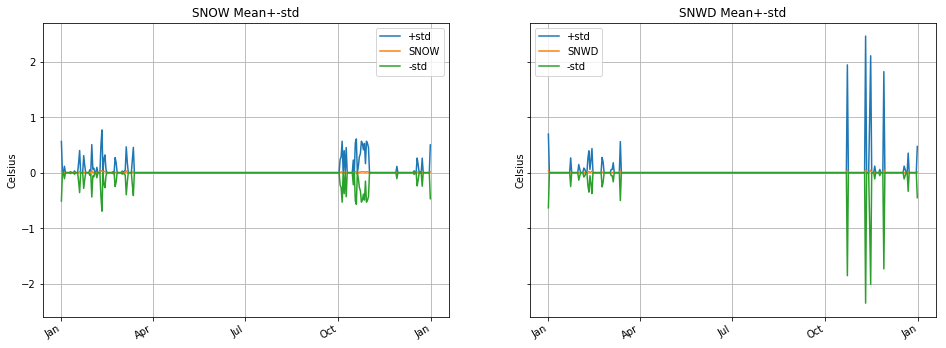

In [16]:
plot_pair(['SNOW', 'SNWD'],'',plot_mean_std)

### plotting top 3 eigenvectors

In [17]:
def plot_eigen(m,s,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title=m+' Top Eigenvectors', labels=[1,2,3])

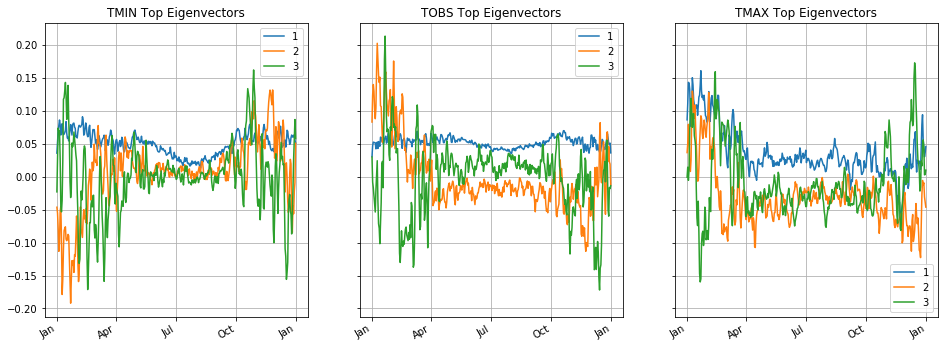

In [18]:
plot_pair(['TMIN','TOBS','TMAX'],'',plot_eigen)

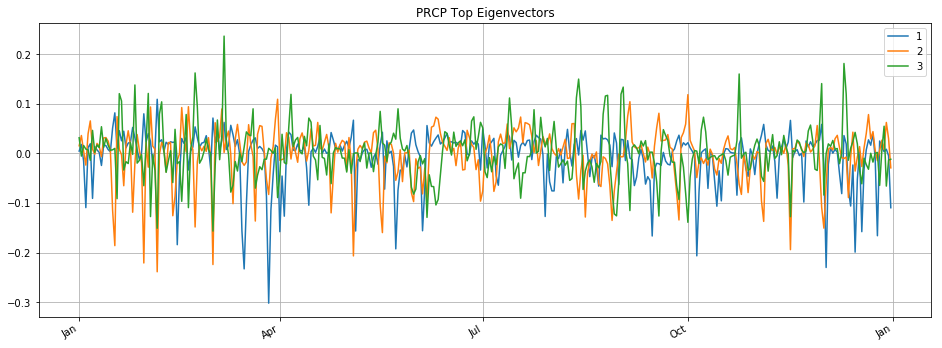

In [19]:
plot_pair(['PRCP'],'',plot_eigen)

In [ ]:
plot_pair(['SNOW', 'SNWD'],'',plot_eigen)

### Script for plotting percentage of variance explained

In [20]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=365
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

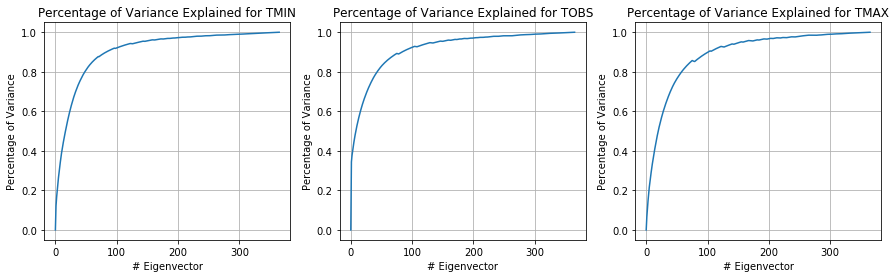

In [21]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

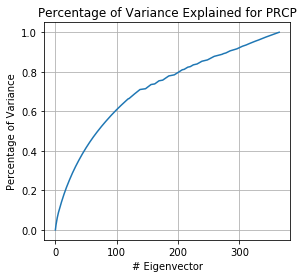

In [23]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['PRCP']:
    pltVarExplained(j)
    j+=1 

In [ ]:
sc.stop()